# Circle Adaptive Augmentation Training

This notebook runs an adaptive augmentation loop for the `circle` dataset:
- Loads an already trained posterior model
- Enlarges the prior support (increase circle radius upper bound)
- Iteratively samples new parameters from the posterior under a chosen observation, simulates new data, merges, and retrains
- Saves the updated posterior after each round


In [2]:
from pathlib import Path
import sys
# Project path setup
project_root = Path.cwd()
if (project_root / 'src').exists():
    pass
else:
    # Fallback: user-specific path
    project_root = Path('/home/chu034/Yaohang_Li/cDiff')


if not project_root.exists() or not (project_root / 'src').exists():
    raise FileNotFoundError(f"找不到项目目录或 src: {project_root}")

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"项目路径: {project_root}")
print("Python 路径已更新")


项目路径: /home/chu034/Yaohang_Li/cDiff
Python 路径已更新


In [3]:
import os
import torch
import numpy as np
import pandas as pd

from datasets import load_dataset
from models.neural_sampler import NormalizingFlowPosteriorSampler, DiffusionPosteriorSampler

# Utilities from this repo
from utils import load_torch_model, SET_SEED

# Select device
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")


CUDA available: True


In [4]:
def set_circle_prior_radius(max_radius: float):
    import datasets.circle
    datasets.circle.hyperpar_dict["z_max"] = float(max_radius)
    print(f"circle prior z_max set to {max_radius}")


def load_posterior_model(model_type: str,
                         y_dim: int,
                         theta_dim: int,
                         use_encoder: bool,
                         device: torch.device,
                         alpha: float,
                         num_hidden_layer: int,
                         data_type: str,
                         save_path: str,
                         epochs: int,
                         seed: int):
    if model_type == "NormalizingFlow":
        model = NormalizingFlowPosteriorSampler(
            y_dim=y_dim, x_dim=theta_dim, n_summaries=256,
            hidden_dim_decoder=32, n_flows_decoder=32, alpha=alpha, device=device,
            use_encoder=use_encoder, data_type=data_type
        ).to(device)
    elif model_type == "Diffusion":
        sigma_data = 0.5
        model = DiffusionPosteriorSampler(
            y_dim=y_dim, x_dim=theta_dim, n_summaries=1,
            num_hidden_layer=num_hidden_layer, device=device, use_encoder=use_encoder, data_type=data_type, sigma_data=sigma_data
        ).to(device)
    else:
        raise NotImplementedError

    model = load_torch_model(model, save_path, epochs, seed, model_type)
    model.eval()
    print("Loaded posterior model from:", save_path)
    return model


In [5]:
# ====== Config (edit here) ======
save_path = "/home/chu034/Yaohang_Li/cDiff/result"
dataset = "circle"  # fixed in this notebook
use_cuda_index = 0

# Training and model
epochs = 3000  # per round retrain epochs
lr = 1e-3
model_type = "Diffusion"  # "Diffusion" or "NormalizingFlow"
alpha = 0.1
use_encoder = False
data_type = "iid"
num_hidden_layer = 4

# Data loading
n_batches = 20
batch_size = 512
seed_start = 1

# Adaptive loop
n_rounds = 5
num_adapt = 200
obs_dim = 10  # length of repeated scalar observations

# Big prior radius
big_radius = 25.0  # expand from default 2.0 to 4.0

# ====== Setup ======
os.makedirs(save_path, exist_ok=True)
SET_SEED(seed_start)
device = torch.device(f"cuda:{use_cuda_index}" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda:0


In [6]:
# Rebuild dataloader and training tensors with fixed-length observations
# This cell fixes concat errors by setting n_sample=obs_dim
set_circle_prior_radius(2.0)
dataset_generator, sample_theta_fn, sample_data_fn = load_dataset(dataset)

dl, ds = dataset_generator(n_batches, batch_size, n_sample=obs_dim, return_ds=True)

theta_list, x_list = [], []
for theta_batch, x_batch in dl:
    theta_list.append(theta_batch)
    x_list.append(x_batch)

theta_train = torch.cat(theta_list, dim=0)
x_train = torch.cat(x_list, dim=0)

print("[Fixed] theta_train:", tuple(theta_train.shape))
print("[Fixed] x_train:", tuple(x_train.shape))

y_dim = x_train.shape[-1]
theta_dim = theta_train.shape[1]

# Load original posterior model
posterior = load_posterior_model(
    model_type=model_type,
    y_dim=y_dim,
    theta_dim=theta_dim,
    use_encoder=use_encoder,
    device=device,
    alpha=alpha,
    num_hidden_layer=num_hidden_layer,
    data_type=data_type,
    save_path=f"{save_path}/{dataset}",
    epochs=epochs,
    seed=seed_start,
)

# Switch to big prior (expand support)
set_circle_prior_radius(big_radius)


circle prior z_max set to 2.0
[Fixed] theta_train: (10240, 2)
[Fixed] x_train: (10240, 10, 1)
Model loaded from /home/chu034/Yaohang_Li/cDiff/result/circle/3000_seed=1_Diffusion.pth
Loaded posterior model from: /home/chu034/Yaohang_Li/cDiff/result/circle
circle prior z_max set to 25.0


/home/chu034/Yaohang_Li/cDiff/utils.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(file_name))


In [21]:


# Observed radius set: repeated constant 3.0, shape (1, obs_dim, 1)
x_obs_set = torch.full((obs_dim, 1), 25.0, dtype=torch.float32, device=device)


In [22]:
x_obs_set

tensor([[25.],
        [25.],
        [25.],
        [25.],
        [25.],
        [25.],
        [25.],
        [25.],
        [25.],
        [25.]], device='cuda:0')

In [23]:
posterior.eval()
posterior.sample(x_obs_set, num_steps=300)

tensor([[ -8.8446, -19.4349],
        [ -8.8446, -19.4349],
        [ -8.8446, -19.4349],
        [ -8.8446, -19.4349],
        [ -8.8446, -19.4349],
        [ -8.8446, -19.4349],
        [ -8.8447, -19.4350],
        [ -8.8446, -19.4349],
        [ -8.8446, -19.4349],
        [ -8.8446, -19.4349]], device='cuda:0')

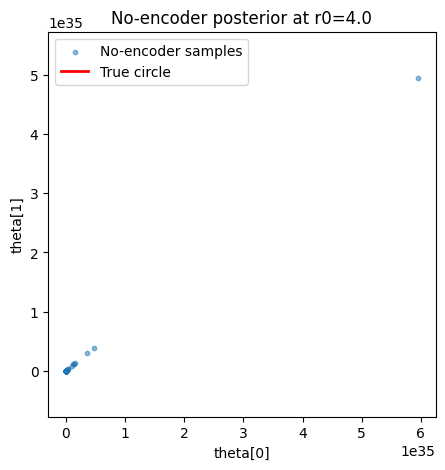

In [17]:
# No-encoder: sample at specific radius r0 and overlay true circle

import os
import torch
import numpy as np
import matplotlib.pyplot as plt

r0_noenc = 4.0
num_samples = 1000

with torch.no_grad():
    cond_noenc = torch.full((num_samples, 1), r0_noenc, device=device)
    samples_noenc = posterior.sample(cond_noenc, num_steps=100).detach().cpu().numpy()

ang = np.linspace(0, 2*np.pi, 400)
true_x = r0_noenc * np.cos(ang)
true_y = r0_noenc * np.sin(ang)

plt.figure(figsize=(5,5))
plt.scatter(samples_noenc[:,0], samples_noenc[:,1], s=10, alpha=0.5, label='No-encoder samples')
plt.plot(true_x, true_y, 'r-', lw=2, label='True circle')
plt.axis('equal')
plt.xlabel('theta[0]')
plt.ylabel('theta[1]')
plt.title(f'No-encoder posterior at r0={r0_noenc}')
plt.legend()
plt.show()



--- Round 1/5 ---


/home/chu034/Yaohang_Li/cDiff/models/diffusion.py:233: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma)
/home/chu034/Yaohang_Li/cDiff/models/diffusion.py:233: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma)


  Epoch 1/3000, Loss: nan
  Epoch 100/3000, Loss: nan
  Epoch 200/3000, Loss: nan
  Epoch 300/3000, Loss: nan
  Epoch 400/3000, Loss: nan
  Epoch 500/3000, Loss: nan
  Epoch 600/3000, Loss: nan
  Epoch 700/3000, Loss: nan
  Epoch 800/3000, Loss: nan
  Epoch 900/3000, Loss: nan
  Epoch 1000/3000, Loss: nan
  Epoch 1100/3000, Loss: nan
  Epoch 1200/3000, Loss: nan
  Epoch 1300/3000, Loss: nan
  Epoch 1400/3000, Loss: nan
  Epoch 1500/3000, Loss: nan
  Epoch 1600/3000, Loss: nan
  Epoch 1700/3000, Loss: nan
  Epoch 1800/3000, Loss: nan
  Epoch 1900/3000, Loss: nan
  Epoch 2000/3000, Loss: nan
  Epoch 2100/3000, Loss: nan
  Epoch 2200/3000, Loss: nan
  Epoch 2300/3000, Loss: nan
  Epoch 2400/3000, Loss: nan
  Epoch 2500/3000, Loss: nan
  Epoch 2600/3000, Loss: nan
  Epoch 2700/3000, Loss: nan
  Epoch 2800/3000, Loss: nan
  Epoch 2900/3000, Loss: nan
  Epoch 3000/3000, Loss: nan
Round 1 done. Saved: /home/chu034/Yaohang_Li/cDiff/result/bigposterior_round1.pt


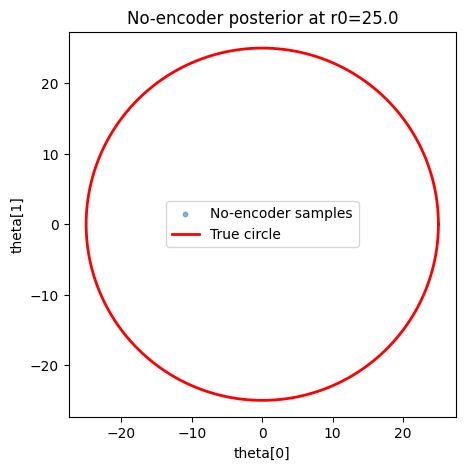


--- Round 2/5 ---
  Epoch 1/3000, Loss: nan
  Epoch 100/3000, Loss: nan
  Epoch 200/3000, Loss: nan
  Epoch 300/3000, Loss: nan
  Epoch 400/3000, Loss: nan
  Epoch 500/3000, Loss: nan
  Epoch 600/3000, Loss: nan
  Epoch 700/3000, Loss: nan
  Epoch 800/3000, Loss: nan
  Epoch 900/3000, Loss: nan
  Epoch 1000/3000, Loss: nan
  Epoch 1100/3000, Loss: nan
  Epoch 1200/3000, Loss: nan
  Epoch 1300/3000, Loss: nan
  Epoch 1400/3000, Loss: nan
  Epoch 1500/3000, Loss: nan
  Epoch 1600/3000, Loss: nan
  Epoch 1700/3000, Loss: nan
  Epoch 1800/3000, Loss: nan
  Epoch 1900/3000, Loss: nan
  Epoch 2000/3000, Loss: nan
  Epoch 2100/3000, Loss: nan
  Epoch 2200/3000, Loss: nan
  Epoch 2300/3000, Loss: nan
  Epoch 2400/3000, Loss: nan
  Epoch 2500/3000, Loss: nan
  Epoch 2600/3000, Loss: nan
  Epoch 2700/3000, Loss: nan
  Epoch 2800/3000, Loss: nan
  Epoch 2900/3000, Loss: nan
  Epoch 3000/3000, Loss: nan
Round 2 done. Saved: /home/chu034/Yaohang_Li/cDiff/result/bigposterior_round2.pt


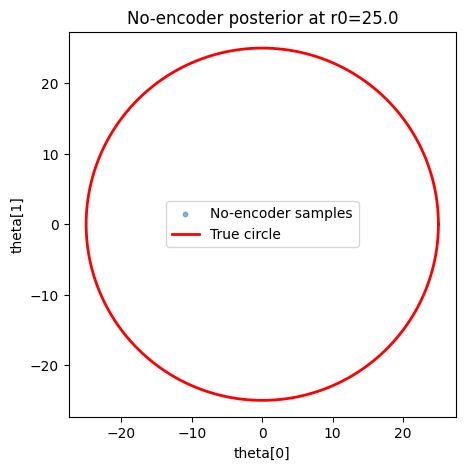


--- Round 3/5 ---
  Epoch 1/3000, Loss: nan


KeyboardInterrupt: 

In [ ]:
# Corrected adaptive augmentation loop with shape fixes and comments
posterior_big = None

# Observed radius set: repeated constant 3.0, shape (1, obs_dim, 1)
x_obs_set = torch.full((1, obs_dim, 1), 25.0, dtype=torch.float32, device=device)

for round_idx in range(n_rounds):
    print(f"\n--- Round {round_idx+1}/{n_rounds} ---")

    model_in_use = posterior_big if (posterior_big is not None) else posterior

    # 1) 采样时用标量半径作为条件，保持 cond_dim=1 与原模型一致
    #    将观测集合在样本维求均值，得到 shape (1, 1)
    y_obs_cond = x_obs_set[0:1].mean(dim=1)  # (1, 1)

    # 2) 按照上述 cond 逐个采样 theta，确保返回 shape (2,) 后堆叠
    samples_list = []
    with torch.no_grad():
        for _ in range(num_adapt):
            th = model_in_use.sample(y_obs_cond, num_steps=18)
            if isinstance(th, tuple):
                th = th[0]
            th = th.squeeze(0)  # (2,)
            samples_list.append(th.detach().cpu())
    new_theta = torch.stack(samples_list, dim=0)  # (num_adapt, 2)

    # 3) 用 new_theta 仿真新观测集 (保持数据接口不变)
    new_x = []
    for i in range(num_adapt):
        theta_i = new_theta[i].numpy()
        obs_set = sample_data_fn({"x": float(theta_i[0]), "y": float(theta_i[1])}, obs_dim)
        new_x.append(torch.tensor(obs_set, dtype=torch.float32))
    new_x = torch.stack(new_x, dim=0)  # (num_adapt, obs_dim, 1)

    # 4) 合并数据
    theta_expanded = torch.cat([theta_train, new_theta], dim=0)
    x_expanded = torch.cat([x_train, new_x], dim=0)

    # # 5) 重新初始化一个 posterior（与 main 中设置一致）
    # if model_type == "NormalizingFlow":
    #     inference_big = NormalizingFlowPosteriorSampler(
    #         y_dim=y_dim, x_dim=theta_dim, n_summaries=256,
    #         hidden_dim_decoder=32, n_flows_decoder=32, alpha=alpha, device=device,
    #         use_encoder=use_encoder, data_type=data_type
    #     ).to(device)
    # else:
    #     inference_big = DiffusionPosteriorSampler(
    #         y_dim=y_dim, x_dim=theta_dim, n_summaries=256,
    #         num_hidden_layer=num_hidden_layer, device=device,
    #         use_encoder=use_encoder, data_type=data_type, sigma_data=0.5
    #     ).to(device)
    inference_big = model_in_use
    optimizer = torch.optim.Adam(inference_big.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

    # 6) 训练时同样将 cond = y 在样本维求均值，得到 [B, 1]
    inference_big.train()
    for epoch in range(epochs):
        permutation = torch.randperm(theta_expanded.size(0))
        for i in range(0, theta_expanded.size(0), batch_size):
            indices = permutation[i:i+batch_size]
            batch_theta = theta_expanded[indices].to(device)
            # 关键修正：cond 使用均值压缩为 (B, 1)，匹配 ScoreNetwork 的 cond_dim=1
            batch_cond = x_expanded[indices].to(device).mean(dim=1)  # (B, 1)

            optimizer.zero_grad()
            loss = inference_big.loss(x=batch_theta, y=batch_cond).mean()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(inference_big.parameters(), max_norm=100.0)
            optimizer.step()
        scheduler.step()
        if (epoch + 1) % 100 == 0 or epoch == 0:
            print(f"  Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

    posterior_big = inference_big.eval()

    # 7) 保存每轮模型
    round_save_path = os.path.join(save_path, f"bigposterior_round{round_idx+1}.pt")
    torch.save(posterior_big.state_dict(), round_save_path)
    print(f"Round {round_idx+1} done. Saved: {round_save_path}")
    # No-encoder: sample at specific radius r0 and overlay true circle

    import os
    import torch
    import numpy as np
    import matplotlib.pyplot as plt
    r0_noenc = 25.0
    num_samples = 1000

    with torch.no_grad():
        cond_noenc = torch.full((num_samples, 1), r0_noenc, device=device)
        samples_noenc = posterior_big.sample(cond_noenc, num_steps=100).detach().cpu().numpy()

    ang = np.linspace(0, 2*np.pi, 400)
    true_x = r0_noenc * np.cos(ang)
    true_y = r0_noenc * np.sin(ang)

    plt.figure(figsize=(5,5))
    plt.scatter(samples_noenc[:,0], samples_noenc[:,1], s=10, alpha=0.5, label='No-encoder samples')
    plt.plot(true_x, true_y, 'r-', lw=2, label='True circle')
    plt.axis('equal')
    plt.xlabel('theta[0]')
    plt.ylabel('theta[1]')
    plt.title(f'No-encoder posterior at r0={r0_noenc}')
    plt.legend()
    plt.show()



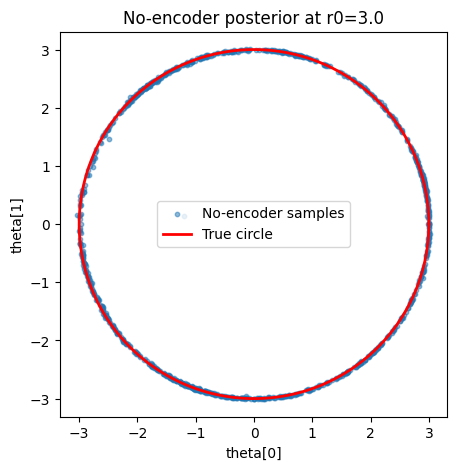

In [ ]:
# No-encoder: sample at specific radius r0 and overlay true circle

import os
import torch
import numpy as np
import matplotlib.pyplot as plt
r0_noenc = 3.0
num_samples = 1000

with torch.no_grad():
    cond_noenc = torch.full((num_samples, 1), r0_noenc, device=device)
    samples_noenc = posterior_big.sample(cond_noenc, num_steps=300).detach().cpu().numpy()

ang = np.linspace(0, 2*np.pi, 400)
true_x = r0_noenc * np.cos(ang)
true_y = r0_noenc * np.sin(ang)

plt.figure(figsize=(5,5))
plt.scatter(samples_noenc[:,0], samples_noenc[:,1], s=10, alpha=0.5, label='No-encoder samples')
plt.plot(true_x, true_y, 'r-', lw=2, label='True circle')
plt.axis('equal')
plt.xlabel('theta[0]')
plt.ylabel('theta[1]')
plt.title(f'No-encoder posterior at r0={r0_noenc}')
plt.legend()
plt.show()


In [ ]:
samples_noenc

array([[-12.246926 ,  -1.5352948],
       [-12.246926 ,  -1.5352948],
       [-12.246926 ,  -1.5352948],
       ...,
       [-12.246926 ,  -1.5352948],
       [-12.246926 ,  -1.5352948],
       [-12.246926 ,  -1.5352948]], shape=(1000, 2), dtype=float32)